<img src="https://assets-global.website-files.com/63299e8be533faffbc123045/636552d0b570aa56ec6e2683_customer-churn-hero.png">

# Project Goals:


The overarching goal of this project is twofold: firstly, to showcase my proficiency in neural network architectures by meticulously comparing ANN performance against other established algorithms. Secondly, to construct a robust and accurate predictive model for customer churn, unraveling the intricate patterns within the dataset through exploratory data analysis (EDA) and advanced feature engineering.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


For more context. https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113

In [5]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

# Model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Additional utilities
from tensorflow.keras.utils import to_categorical

# Callbacks for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualizing model architecture
from tensorflow.keras.utils import plot_model


In [6]:
# Loading in the data.
churn_data = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## EDA
- I am looking to handle missing date, outliers and ensure consistency in the data.

In [7]:
churn_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [8]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- From info already we don't have missing data so it seems. 
- We have got 20 columns and already I am gonna be looking at some lovely feature extractions 
- Based on this total charges should not be object so I need to change that float.

In [9]:
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float)
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- From not having missing data to having missing data now. So i noticed that multiplying monthly charges and tenure cn give us the best possible outcome to replace the missing values in TotalCharges.

In [10]:
# I found out that the tenure * monthly charge is like the most accurate data that can be used in solving the missing values. 
#churn_update.head(10)

# So it might not be the most accurate but very close. 
# Assuming 'tenure', 'MonthlyCharges', and 'TotalCharges' are the columns
churn_data['TotalCharges'] = churn_data['TotalCharges'].fillna(churn_data['tenure'] * churn_data['MonthlyCharges'])


In [11]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
churn_data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


# Visualization

In [13]:
churn_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [14]:
import plotly.express as px

# Since churn is where the business problem is at then we are gonna look at the distrubutions. 
churn_distribution = churn_data['Churn'].value_counts().reset_index()
churn_distribution.columns = ['Churn', 'Count']

fig = px.pie(churn_distribution, values='Count', names='Churn', title='Churn Distribution')
fig.show()

- Already we can see some imbalance in the data where the main business problem is represented 26.5% of the data 

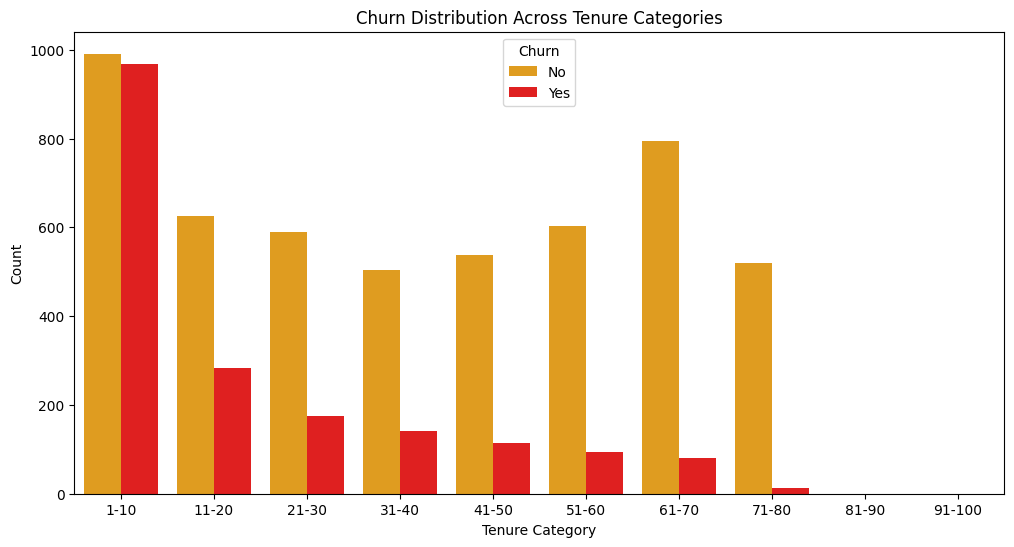

In [15]:
# Numeric distribution of the data. 
# Bin the 'tenure' into 5 categories
# Define tenure category labels
category_labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Bin the 'tenure' into 10 categories
churn_data['TenureCategory'] = pd.cut(churn_data['tenure'], bins=range(0, 101, 10), labels=category_labels)

# Set the color palette for 'Yes' and 'No'
colors = {'Yes': 'red', 'No': 'orange'}

# Create a bar plot to compare churn across tenure categories using Seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x='TenureCategory', hue='Churn', data=churn_data, palette=colors)
plt.title('Churn Distribution Across Tenure Categories')
plt.xlabel('Tenure Category')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

- Generally we can see that churn reduces as the customers stay longer. 

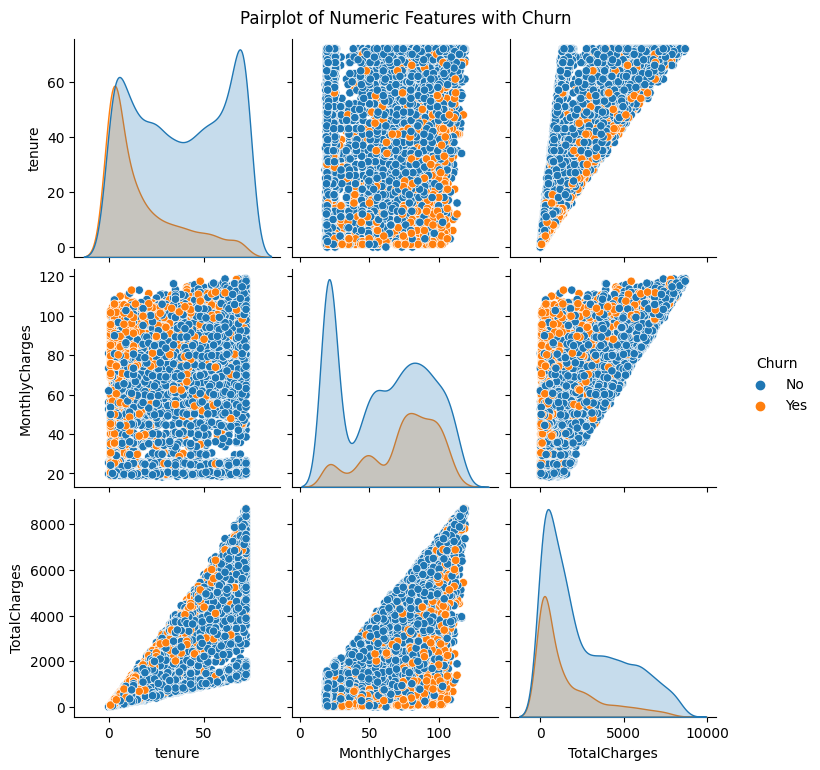

In [16]:
sns.pairplot(churn_data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn', diag_kind='kde')
plt.suptitle('Pairplot of Numeric Features with Churn', y=1.02)
plt.show()

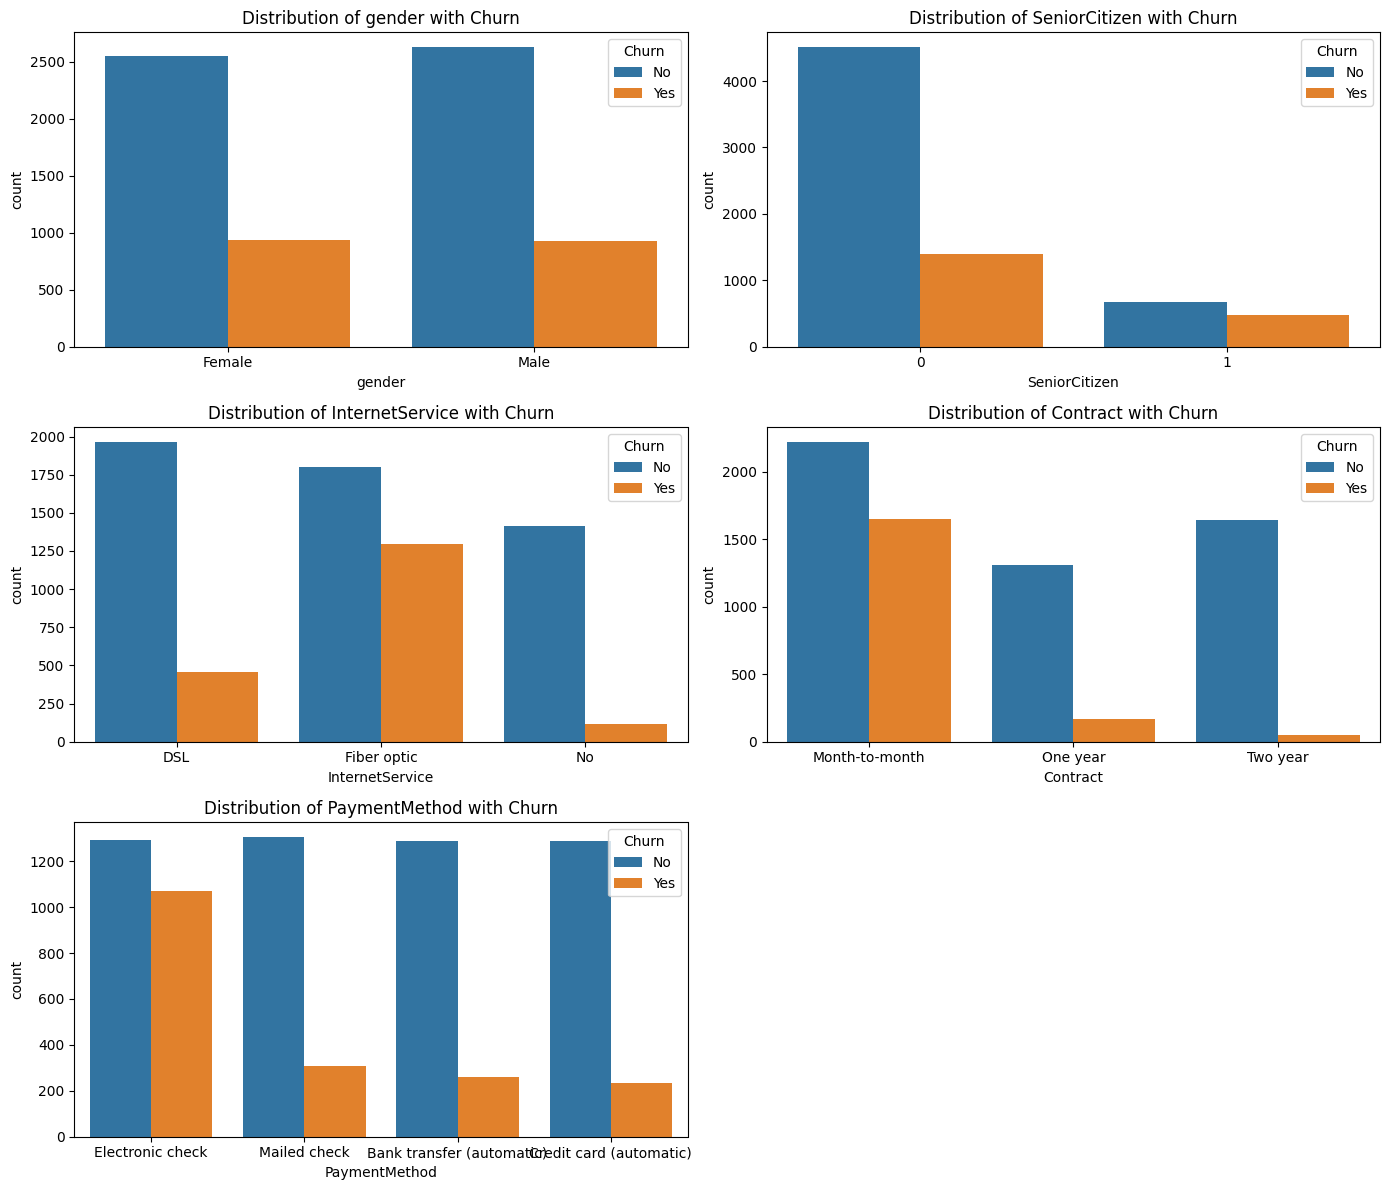

In [17]:
plt.figure(figsize=(14, 12))
for i, col in enumerate(['gender', 'SeniorCitizen', 'InternetService', 'Contract', 'PaymentMethod'], start=1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, hue='Churn', data=churn_data)
    plt.title(f'Distribution of {col} with Churn')
plt.tight_layout()
plt.show()

- Based on this distribution we can get a sense of some factors that can make customers churn, looking at month-to-month contract even though we have customers staying it's better to keep them or convert them to long term contracts. 
- I would be running a feature important and then come back to do some more visualization. 

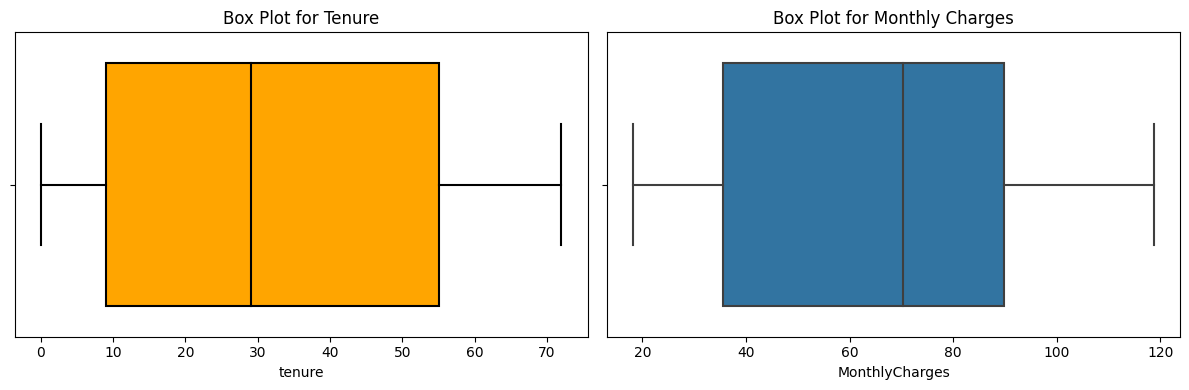

In [18]:
# Set up a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) # with the nrow and ncol that just helps with the style.

# Box plot for 'tenure'
sns.boxplot(x='tenure', data=churn_data, ax=axes[0], color='black', boxprops=dict(facecolor='orange'))
axes[0].set_title('Box Plot for Tenure')

# Box plot for 'MonthlyCharges'
sns.boxplot(x='MonthlyCharges', data=churn_data, ax=axes[1])
axes[1].set_title('Box Plot for Monthly Charges')

# Adjust layout
plt.tight_layout()
plt.show()

- We can see that there are no outliers in this case. 

## Feature Engineering 

In [19]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'TenureCategory'],
      dtype='object')

In [20]:
# So I feel like I would be dropping so many columns and I would like to create a function to help me with this.

def drop_col(dataset, columns_to_drop):
    """
    Drops specified columns from a dataset.

    Parameters:
    - dataset (pd.DataFrame): The DataFrame from which columns should be dropped.
    - columns_to_drop (list): List of column names to be dropped.

    Returns:
    - pd.DataFrame: The updated DataFrame after dropping specified columns.
    """
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input 'dataset' must be a pandas DataFrame.")

    # Check if columns_to_drop is a list
    if not isinstance(columns_to_drop, list):
        raise ValueError("Input 'columns_to_drop' must be a list of column names.")

    # Drop specified columns
    updated_dataset = dataset.drop(columns=columns_to_drop, errors='ignore')

    return updated_dataset

In [21]:
columns_to_drop = ['customerID', 'TenureCategory'] # customerID is not relevant because this is just an identification for customers and it wouldn't or doesn't not affect if they stay or leave. 
churn_update = drop_col(churn_data, columns_to_drop)

In [22]:
churn_update.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
churn_update['Churn'].value_counts(normalize = True)* 100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

- So we can see that there is an imbalance with the data where we have about 27% of customers churning.


*I find this interesting when I do a special try of split to make sure my dev data contains 95% churn == Yes*

In [24]:
# Checking the unique values in categorical columns.

def uniq_values_object_col(dataset):
    """
    Returns unique values for columns with dtype as object in a DataFrame.

    Parameters:
    - dataset (pd.DataFrame): The DataFrame for which unique values should be retrieved.

    Returns:
    - dict: A dictionary where keys are column names, and values are sets of unique values.
    """
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input 'dataset' must be a pandas DataFrame.")

    unique_values_dict = {}

    # Loop through columns
    for column in dataset.columns:
        if dataset[column].dtype == 'object':
            unique_values_dict[column] = set(dataset[column].unique())

    return unique_values_dict
    

In [25]:
uniq_values_object_col(churn_update)

{'gender': {'Female', 'Male'},
 'Partner': {'No', 'Yes'},
 'Dependents': {'No', 'Yes'},
 'PhoneService': {'No', 'Yes'},
 'MultipleLines': {'No', 'No phone service', 'Yes'},
 'InternetService': {'DSL', 'Fiber optic', 'No'},
 'OnlineSecurity': {'No', 'No internet service', 'Yes'},
 'OnlineBackup': {'No', 'No internet service', 'Yes'},
 'DeviceProtection': {'No', 'No internet service', 'Yes'},
 'TechSupport': {'No', 'No internet service', 'Yes'},
 'StreamingTV': {'No', 'No internet service', 'Yes'},
 'StreamingMovies': {'No', 'No internet service', 'Yes'},
 'Contract': {'Month-to-month', 'One year', 'Two year'},
 'PaperlessBilling': {'No', 'Yes'},
 'PaymentMethod': {'Bank transfer (automatic)',
  'Credit card (automatic)',
  'Electronic check',
  'Mailed check'},
 'Churn': {'No', 'Yes'}}

In [26]:
# Based of the documentation IBM provided we need change the "No......" to just No

churn_update = churn_update.replace({
    'No internet service': 'No',
    'No phone service': 'No'
})

In [27]:
# One hot code 
churn_update = churn_update.replace({
    'Yes': 1 ,
    'No': 0,
    'Female': 0,
    'Male': 1
})

In [28]:
uniq_values_object_col(churn_update)

{'InternetService': {0, 'DSL', 'Fiber optic'},
 'Contract': {'Month-to-month', 'One year', 'Two year'},
 'PaymentMethod': {'Bank transfer (automatic)',
  'Credit card (automatic)',
  'Electronic check',
  'Mailed check'}}

In [29]:
## Now I have this 3 columns so I would just use dummy variable.
# Assuming 'churn_update' is your DataFrame
categorical_columns = churn_update.select_dtypes(include=['object']).columns

# Create dummy variables for categorical columns
churn_update = pd.get_dummies(data = churn_update,
                             columns = categorical_columns)

In [30]:
churn_update.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,False,True,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,1,0,1,...,False,True,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,0,1,1,0,...,False,True,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,1,0,1,...,False,True,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False


In [31]:
churn_update = churn_update.astype(int)

In [32]:
churn_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   gender                                   7043 non-null   int64
 1   SeniorCitizen                            7043 non-null   int64
 2   Partner                                  7043 non-null   int64
 3   Dependents                               7043 non-null   int64
 4   tenure                                   7043 non-null   int64
 5   PhoneService                             7043 non-null   int64
 6   MultipleLines                            7043 non-null   int64
 7   OnlineSecurity                           7043 non-null   int64
 8   OnlineBackup                             7043 non-null   int64
 9   DeviceProtection                         7043 non-null   int64
 10  TechSupport                              7043 non-null   int64
 11  Stre

### Visualizations

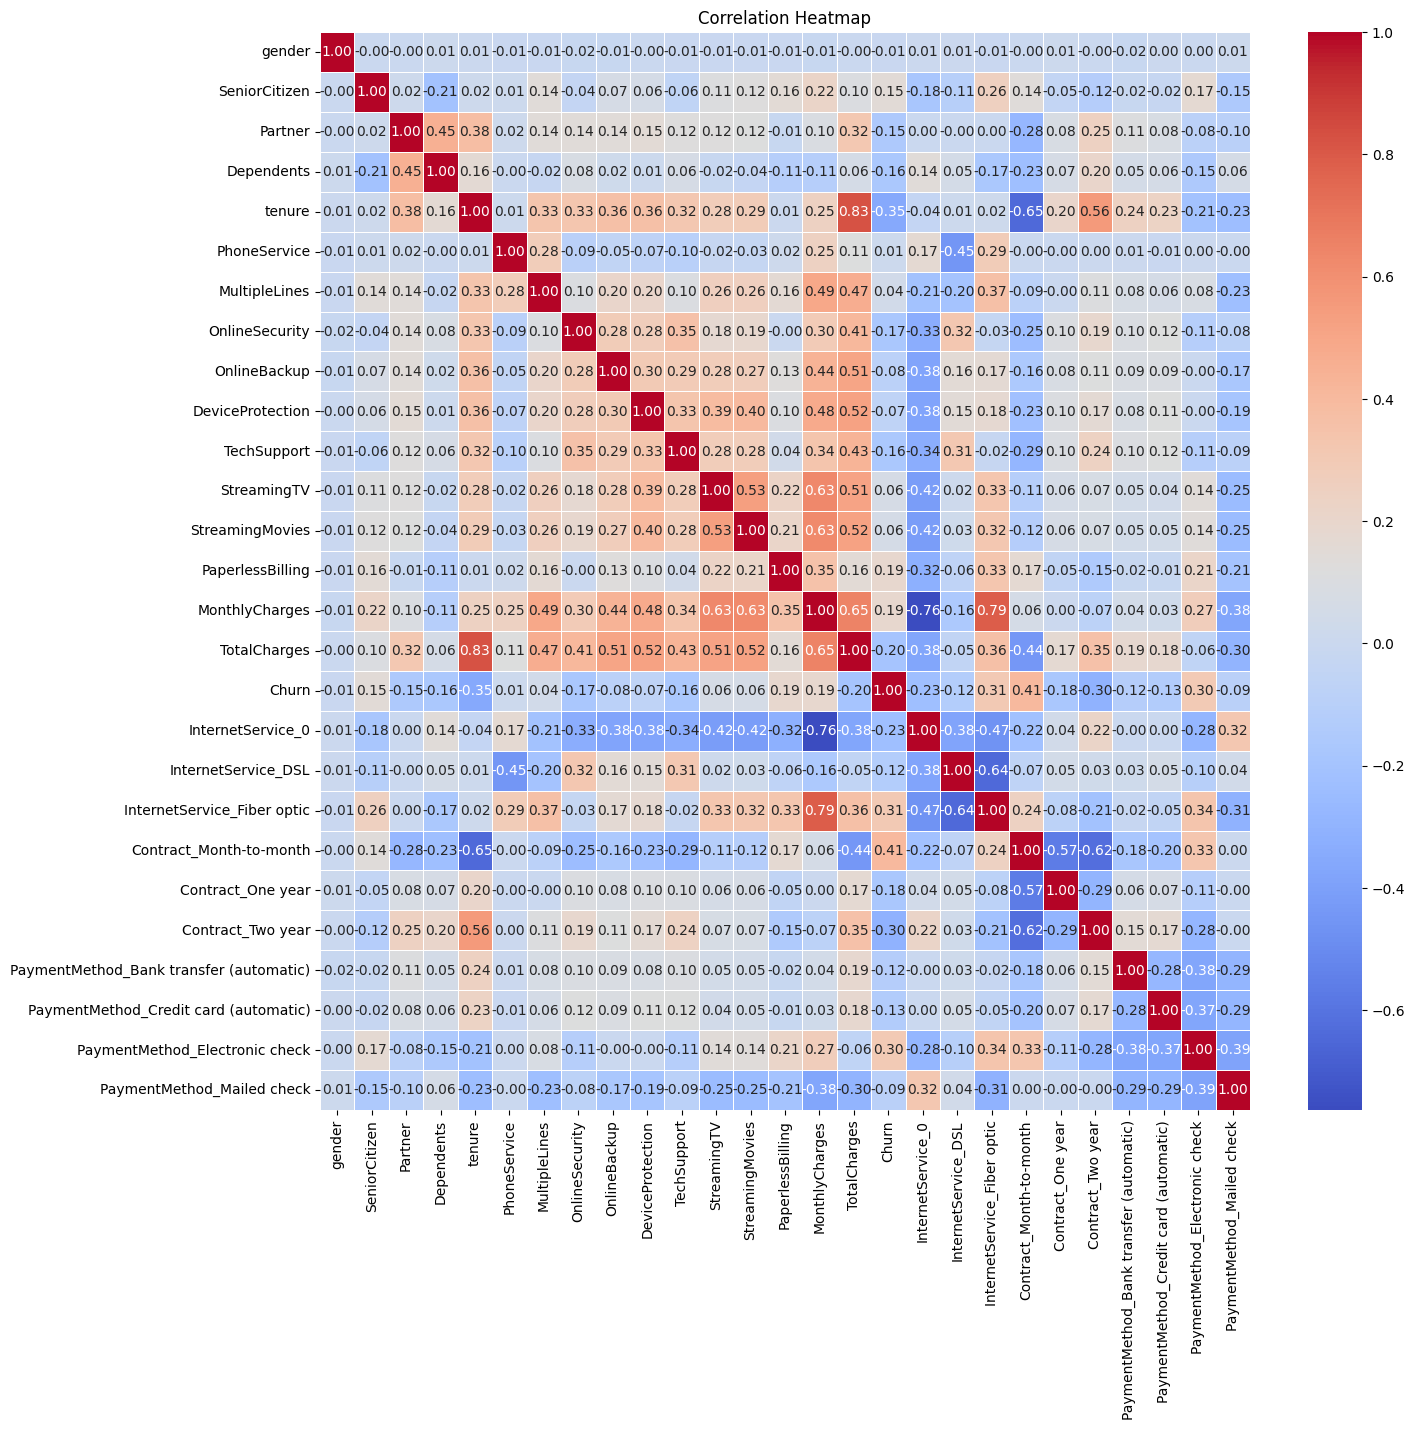

In [33]:
correlation_matrix = churn_update.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 14))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5)

# Display the plot
plt.title('Correlation Heatmap')
plt.show()

In [34]:
# Feature scaling:
scaler = StandardScaler()
churn_scaled = pd.DataFrame(scaler.fit_transform(churn_update), columns=churn_update.columns)

churn_scaled.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,-0.854176,-0.633933,1.378241,-0.723968,...,-0.525927,1.381712,-0.885660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.854176,1.577454,-0.725563,1.381277,...,-0.525927,1.381712,-0.885660,-1.105970,1.944582,-0.562975,-0.529885,-0.525047,-0.711026,1.835513
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,1.577454,1.378241,-0.723968,...,-0.525927,1.381712,-0.885660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,-0.854176,1.577454,-0.725563,1.381277,...,-0.525927,1.381712,-0.885660,-1.105970,1.944582,-0.562975,1.887201,-0.525047,-0.711026,-0.544807
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,-0.633933,-0.725563,-0.723968,...,-0.525927,-0.723740,1.129102,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807
5,-1.009559,-0.439916,-0.966622,-0.654012,-0.992402,0.327438,1.170719,-0.633933,-0.725563,1.381277,...,-0.525927,-0.723740,1.129102,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807
6,0.990532,-0.439916,-0.966622,1.529024,-0.422317,0.327438,1.170719,-0.633933,1.378241,-0.723968,...,-0.525927,-0.723740,1.129102,0.904184,-0.514249,-0.562975,-0.529885,1.904590,-0.711026,-0.544807
7,-1.009559,-0.439916,-0.966622,-0.654012,-0.910961,-3.054010,-0.854176,1.577454,-0.725563,-0.723968,...,-0.525927,1.381712,-0.885660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513
8,-1.009559,-0.439916,1.034530,-0.654012,-0.177995,0.327438,1.170719,-0.633933,-0.725563,1.381277,...,-0.525927,-0.723740,1.129102,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807
9,0.990532,-0.439916,-0.966622,1.529024,1.206498,0.327438,-0.854176,1.577454,1.378241,-0.723968,...,-0.525927,1.381712,-0.885660,-1.105970,1.944582,-0.562975,1.887201,-0.525047,-0.711026,-0.544807


## Model

- I Wanto use logistic regression as the bench mark of how good my ANN should be. 
- Run LG get accuracy and other martic
- Run ANN 
- Finetune if needed.

In [35]:
X = churn_scaled.drop('Churn', axis=1)  # Features
y = churn_update['Churn']  # Target variable

In [36]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_0,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,-0.854176,-0.633933,1.378241,-0.723968,...,-0.525927,1.381712,-0.885660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807
1,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.854176,1.577454,-0.725563,1.381277,...,-0.525927,1.381712,-0.885660,-1.105970,1.944582,-0.562975,-0.529885,-0.525047,-0.711026,1.835513
2,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,1.577454,1.378241,-0.723968,...,-0.525927,1.381712,-0.885660,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,-0.711026,1.835513
3,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,-0.854176,1.577454,-0.725563,1.381277,...,-0.525927,1.381712,-0.885660,-1.105970,1.944582,-0.562975,1.887201,-0.525047,-0.711026,-0.544807
4,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.854176,-0.633933,-0.725563,-0.723968,...,-0.525927,-0.723740,1.129102,0.904184,-0.514249,-0.562975,-0.529885,-0.525047,1.406418,-0.544807


In [37]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [38]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Train the model on the training set
logistic_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logistic_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)


In [39]:
y_train_pred = logistic_model.predict(X_train)

# Evaluate the performance on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
classification_report_train = classification_report(y_train, y_train_pred)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)

print(f'Training Accuracy: {accuracy_train:.2f}')
print('Classification Report for Training Set:')
print(classification_report_train)
print('Confusion Matrix for Training Set:')
print(confusion_matrix_train)
y_pred = logistic_model.predict(X_test)

# Evaluate the performance on the training set
accuracy_test = accuracy_score(y_test, y_pred)
classification_report_test = classification_report(y_test, y_pred)
confusion_matrix_test = confusion_matrix(y_test, y_pred)

print(f'Test Accuracy: {accuracy_test:.2f}')
print('Classification Report for Test Set:')
print(classification_report_test)
print('Confusion Matrix for Test Set:')
print(confusion_matrix_test)

Training Accuracy: 0.81
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634

Confusion Matrix for Training Set:
[[3717  422]
 [ 668  827]]
Test Accuracy: 0.80
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

Confusion Matrix for Test Set:
[[924 111]
 [168 206]]


- The model this just decent but we can see that the model isn't doing so well with churn == Yes meaning resampling can help in this case or we get more churn data but in this case we would just be resampling the data. 


## So I can see one issue might be with imbalanced data already but I want to make my ANN first then start tackling the issues. 

# ANN version 1

In [40]:
# Model version 1 
#initializing model 

def plot_training_history(model, X_train, y_train, X_test, y_test):
    """
    Train the model and plot training and validation loss, training and validation accuracy.

    Parameters:
    - model: The Keras model to be trained.
    - X_train, y_train: Training data.
    - X_test, y_test: Testing data.

    Returns:
    - last_epoch_results: Dictionary containing the last epoch's loss and accuracy for training and validation.
    """

    # Get the number of epochs as user input
    epochs = int(input("Enter the number of epochs: "))

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),verbose=0)

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plots
    plt.show()

    # Extract last epoch results
    last_epoch_results = {
        'last_epoch_train_loss': history.history['loss'][-1],
        'last_epoch_val_loss': history.history['val_loss'][-1],
        'last_epoch_train_accuracy': history.history['accuracy'][-1],
        'last_epoch_val_accuracy': history.history['val_accuracy'][-1],
    }

    # Print last epoch metrics
    print("\nLast Epoch Metrics:")
    print(f"Train Loss: {last_epoch_results['last_epoch_train_loss']:.4f}")
    print(f"Validation Loss: {last_epoch_results['last_epoch_val_loss']:.4f}")
    print(f"Train Accuracy: {last_epoch_results['last_epoch_train_accuracy']:.4f}")
    print(f"Validation Accuracy: {last_epoch_results['last_epoch_val_accuracy']:.4f}")

    return last_epoch_results, model.summary()

# Usage example:
# Assuming model_v3 is your Keras model, and X_train, y_train, X_test, y_test are your data
# last_epoch_results = plot_training_history(model_v3, X_train, y_train, X_test, y_test)
# This will prompt you to enter the number of epochs during runtime.



Enter the number of epochs:  100


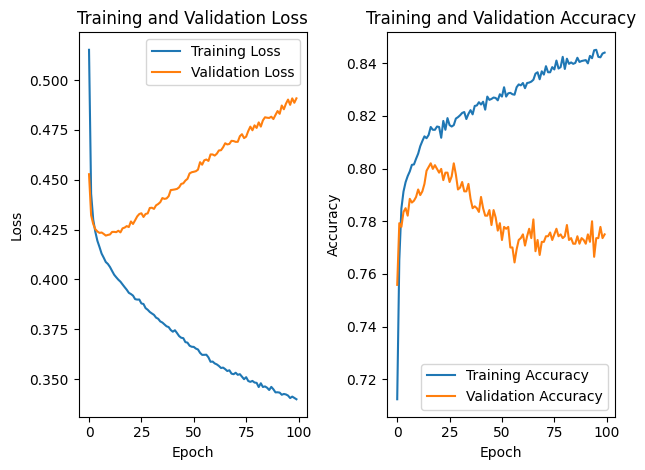


Last Epoch Metrics:
Train Loss: 0.3399
Validation Loss: 0.4909
Train Accuracy: 0.8440
Validation Accuracy: 0.7750
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                702       
                                                                 
 dense_1 (Dense)             (None, 5)                 135       
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 843 (3.29 KB)
Trainable params: 843 (3.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


({'last_epoch_train_loss': 0.339903324842453,
  'last_epoch_val_loss': 0.4908595383167267,
  'last_epoch_train_accuracy': 0.8439829349517822,
  'last_epoch_val_accuracy': 0.7750177383422852},
 None)

In [41]:
''' The ANN architecture is gonna have 2 hidden layer with 5 neutrons and one output'''
model_v1 = Sequential()

# Add the input layer
model_v1.add(Dense(units=X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))

# Add the first hidden layer
model_v1.add(Dense(units=5, activation='relu'))

# Add the output layer
model_v1.add(Dense(units=1, activation='sigmoid'))

# Compiler 
model_v1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(model_v1, X_train, y_train, X_test, y_test)

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model_performance(model, X_train, y_train, X_test, y_test, threshold=0.5):
    # Predictions on the training set
    y_train_pred_probs = model.predict(X_train)
    y_train_pred = (y_train_pred_probs > threshold).astype(int)

    # Evaluate the performance on the training set
    accuracy_train = accuracy_score(y_train, y_train_pred)
    classification_report_train = classification_report(y_train, y_train_pred)
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)

    print(f'Training Accuracy: {accuracy_train:.2f}')
    print('Classification Report for Training Set:')
    print(classification_report_train)
    print('Confusion Matrix for Training Set:')
    print(confusion_matrix_train)

    # Predictions on the test set
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = (y_test_pred_probs > threshold).astype(int)

    # Evaluate the performance on the test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    classification_report_test = classification_report(y_test, y_test_pred)
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

    print(f'Test Accuracy: {accuracy_test:.2f}')
    print('Classification Report for Test Set:')
    print(classification_report_test)
    print('Confusion Matrix for Test Set:')
    print(confusion_matrix_test)

# Usage
evaluate_model_performance(model_v1, X_train, y_train, X_test, y_test)


177/177 [==============================] - 0s 1ms/step
Training Accuracy: 0.85
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4139
           1       0.73      0.68      0.70      1495

    accuracy                           0.85      5634
   macro avg       0.81      0.79      0.80      5634
weighted avg       0.85      0.85      0.85      5634

Confusion Matrix for Training Set:
[[3763  376]
 [ 479 1016]]
45/45 [==============================] - 0s 1ms/step
Test Accuracy: 0.78
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.58      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.78      0.77      1409

Confusion Matrix for Test Set:
[[892 143]
 [174 200]]


- In comparison to the LG model we are very close in accuracy 
- The number of epochs needs to be increased or even the activation functions. 

# ANN Version 2

Enter the number of epochs:  100


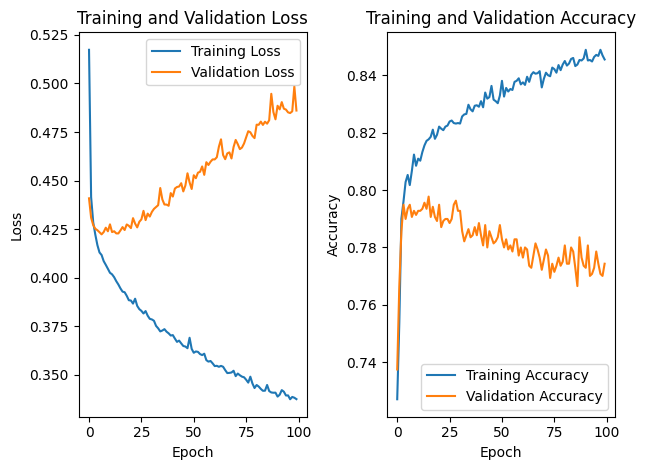


Last Epoch Metrics:
Train Loss: 0.3374
Validation Loss: 0.4861
Train Accuracy: 0.8456
Validation Accuracy: 0.7743
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 26)                702       
                                                                 
 dense_4 (Dense)             (None, 5)                 135       
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 903 (3.53 KB)
Trainable params: 903 (3.53 KB)
Non-trainab

({'last_epoch_train_loss': 0.337423175573349,
  'last_epoch_val_loss': 0.4860683083534241,
  'last_epoch_train_accuracy': 0.8455803990364075,
  'last_epoch_val_accuracy': 0.7743080258369446},
 None)

In [43]:
model_v2 = keras.Sequential([
    keras.layers.Dense(units=X_train.shape[1], activation='relu', input_dim=X_train.shape[1]),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

model_v2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(model_v2,X_train, y_train, X_test, y_test)

In [44]:
evaluate_model_performance(model_v2, X_train, y_train, X_test, y_test)

177/177 [==============================] - 0s 1ms/step
Training Accuracy: 0.85
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4139
           1       0.73      0.70      0.72      1495

    accuracy                           0.85      5634
   macro avg       0.81      0.80      0.81      5634
weighted avg       0.85      0.85      0.85      5634

Confusion Matrix for Training Set:
[[3751  388]
 [ 446 1049]]
45/45 [==============================] - 0s 1ms/step
Test Accuracy: 0.77
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1035
           1       0.58      0.55      0.57       374

    accuracy                           0.77      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.77      0.77      1409

Confusion Matrix for Test Set:
[[884 151]
 [167 207]]


- In version 2 I can see the training is going well and probabely would even hit the 90s but the model isn't doing well in the validation stage and we don't want that.
- So i need to look into regularization,batch norm 
- changing the split having more data in the dev set. 

# ANN Version 3

In [45]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [46]:
X_resampled.shape, X_train.shape

((8278, 26), (5634, 26))

Enter the number of epochs:  100


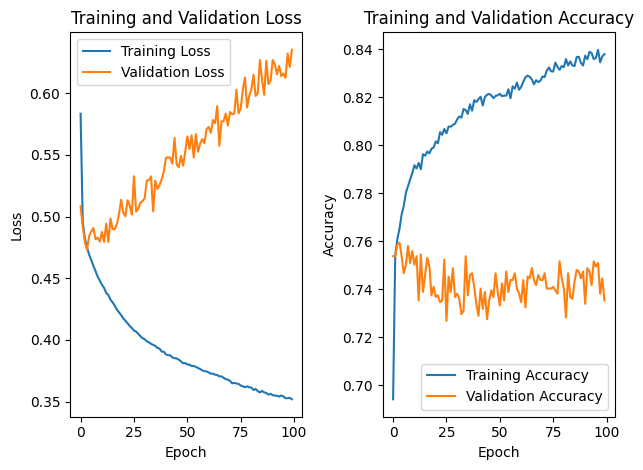


Last Epoch Metrics:
Train Loss: 0.3518
Validation Loss: 0.6353
Train Accuracy: 0.8379
Validation Accuracy: 0.7353
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 26)                702       
                                                                 
 dense_9 (Dense)             (None, 5)                 135       
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                                 
Total params: 843 (3.29 KB)
Trainable params: 843 (3.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
259/259 [==============================] - 0s 1ms/step
Training Accuracy: 0.84
Classification Report for Training Set:
              precision    recall  f1-score   support


In [47]:
model_v3 = Sequential()

# Add the input layer
model_v3.add(Dense(units=X_resampled.shape[1], 
                   activation='relu', 
                   input_dim=X_resampled.shape[1]))

# Add the first hidden layer
model_v3.add(Dense(units=5, activation='relu'))

# Add the output layer
model_v3.add(Dense(units=1, activation='sigmoid'))

# Compiler 
model_v3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(model_v3,X_resampled, y_resampled, X_test, y_test)
evaluate_model_performance(model_v3, X_resampled, y_resampled, X_test, y_test)

- So with resampling we can see that the model is doing better with churn = Yes so we are gonna use batch norm to help use have that home run to help us avoid overfitting 

# Now fine-tuning and using regularization. 

Enter the number of epochs:  100


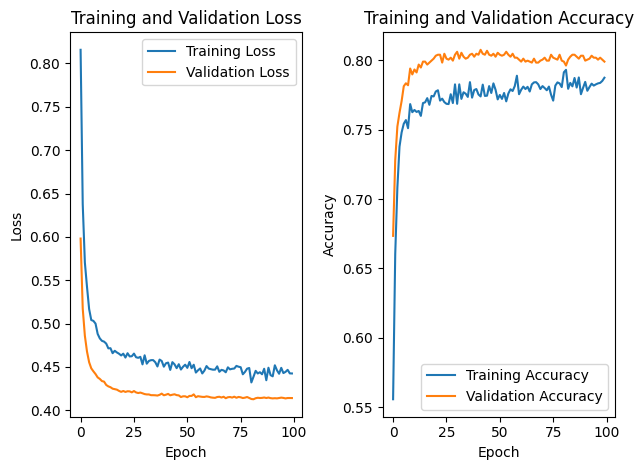


Last Epoch Metrics:
Train Loss: 0.4425
Validation Loss: 0.4142
Train Accuracy: 0.7875
Validation Accuracy: 0.7991
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 11)                297       
                                                                 
 batch_normalization (Batch  (None, 11)                44        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_12 (Dense)            (None, 6)                 72        
                                                                 
 batch_normalization_1 (Bat  (None, 6)                 24        
 chNormalization)                                                
     

In [48]:
# Without resampling... 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

reg_model = Sequential()
reg_model.add(Dense(11, activation='relu', input_dim=X_train.shape[1]))
reg_model.add(BatchNormalization())
reg_model.add(Dropout(0.5))
reg_model.add(Dense(6, activation='relu'))
reg_model.add(BatchNormalization())
reg_model.add(Dropout(0.5))
reg_model.add(Dense(1, activation='sigmoid'))

reg_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(reg_model,X_train, y_train, X_test, y_test)
evaluate_model_performance(reg_model, X_train, y_train, X_test, y_test)

Enter the number of epochs:  100


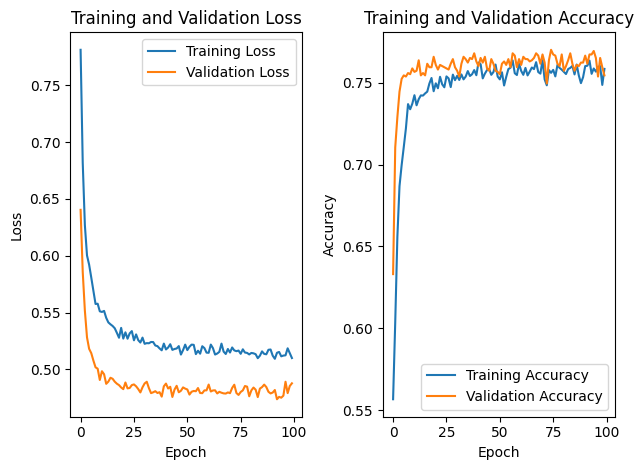


Last Epoch Metrics:
Train Loss: 0.5100
Validation Loss: 0.4878
Train Accuracy: 0.7584
Validation Accuracy: 0.7544
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 11)                297       
                                                                 
 batch_normalization_2 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 11)                0         
                                                                 
 dense_15 (Dense)            (None, 6)                 72        
                                                                 
 batch_normalization_3 (Bat  (None, 6)                 24        
 chNormalization)                                                
     

In [49]:
reg_model_resample = Sequential()
reg_model_resample.add(Dense(11, activation='relu', input_dim=X_resampled.shape[1]))
reg_model_resample.add(BatchNormalization())
reg_model_resample.add(Dropout(0.5))
reg_model_resample.add(Dense(6, activation='relu'))
reg_model_resample.add(BatchNormalization())
reg_model_resample.add(Dropout(0.5))
reg_model_resample.add(Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=0.001)
reg_model_resample.compile(optimizer= opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(reg_model_resample,X_resampled, y_resampled, X_test, y_test)
evaluate_model_performance(reg_model_resample, X_resampled, y_resampled, X_test, y_test)

- I am struggling to get the f1-score on the validation to go higher and the model has become worse.
- I would say I have tried all possible ways to make this model as good as possible using ANN going to try XGBoost/ Randomforest next and see what the results are like.

# XGBoost and RandomForest 

In [50]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [51]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [None, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Perform GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_

# Train the model with the best parameters on the training set
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluate the performance on the training and test sets
evaluate_model_performance(best_rf_model, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/u

Training Accuracy: 0.87
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4139
           1       0.81      0.69      0.74      1495

    accuracy                           0.87      5634
   macro avg       0.85      0.81      0.83      5634
weighted avg       0.87      0.87      0.87      5634

Confusion Matrix for Training Set:
[[3902  237]
 [ 468 1027]]
Test Accuracy: 0.80
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix for Test Set:
[[934 101]
 [183 191]]


In [52]:
# with resampled data 
evaluate_model_performance(best_rf_model, X_resampled, y_resampled, X_test, y_test)

Training Accuracy: 0.81
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83      4139
           1       0.92      0.68      0.78      4139

    accuracy                           0.81      8278
   macro avg       0.84      0.81      0.81      8278
weighted avg       0.84      0.81      0.81      8278

Confusion Matrix for Training Set:
[[3902  237]
 [1316 2823]]
Test Accuracy: 0.80
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix for Test Set:
[[934 101]
 [183 191]]


In [53]:
param_grid_xgb = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = grid_search_xgb.best_params_

# Train the model with the best parameters on the training set
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Evaluate the performance on the training and test sets
evaluate_model_performance(best_xgb_model, X_train, y_train, X_test, y_test)

Training Accuracy: 0.82
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4139
           1       0.69      0.55      0.61      1495

    accuracy                           0.82      5634
   macro avg       0.77      0.73      0.75      5634
weighted avg       0.81      0.82      0.81      5634

Confusion Matrix for Training Set:
[[3772  367]
 [ 673  822]]
Test Accuracy: 0.81
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1035
           1       0.68      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix for Test Set:
[[940  95]
 [172 202]]


In [54]:
evaluate_model_performance(best_xgb_model, X_resampled, y_resampled, X_test, y_test)

Training Accuracy: 0.73
Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4139
           1       0.86      0.56      0.68      4139

    accuracy                           0.73      8278
   macro avg       0.77      0.73      0.72      8278
weighted avg       0.77      0.73      0.72      8278

Confusion Matrix for Training Set:
[[3772  367]
 [1839 2300]]
Test Accuracy: 0.81
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1035
           1       0.68      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix for Test Set:
[[940  95]
 [172 202]]


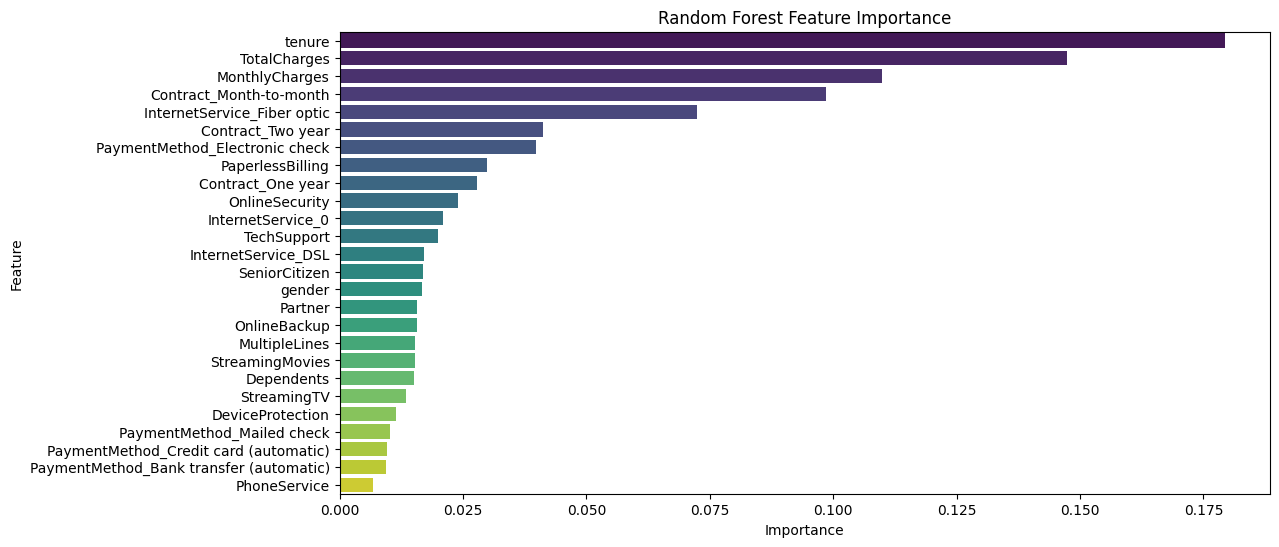

In [55]:
# Get feature importance from the trained Random Forest model
feature_importance_rf = best_rf_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_rf
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)


# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

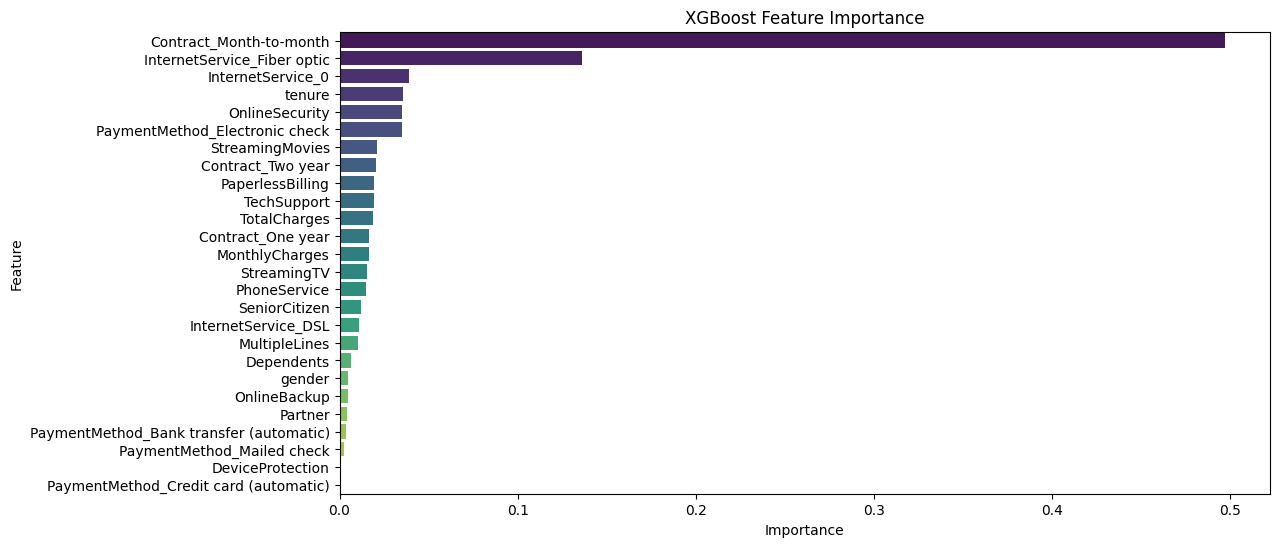

In [56]:
feature_importance_xgb = best_xgb_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_xgb
})

# Sort the DataFrame by importance score in descending order
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()

In [57]:
#trying a new sampling method 

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X,y)   
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

Enter the number of epochs:  100


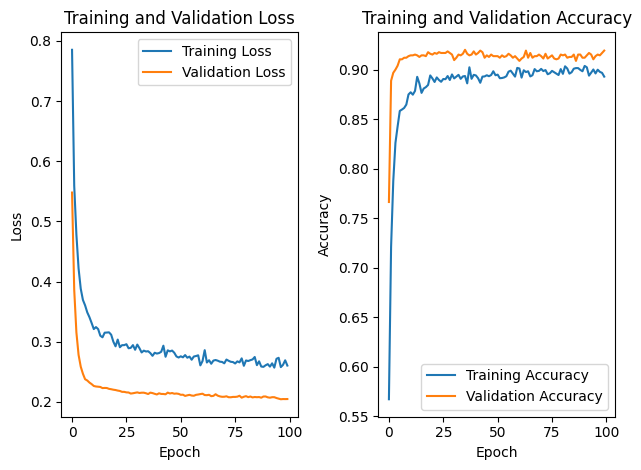


Last Epoch Metrics:
Train Loss: 0.2604
Validation Loss: 0.2048
Train Accuracy: 0.8928
Validation Accuracy: 0.9191
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 11)                297       
                                                                 
 batch_normalization_4 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 11)                0         
                                                                 
 dense_18 (Dense)            (None, 6)                 72        
                                                                 
 batch_normalization_5 (Bat  (None, 6)                 24        
 chNormalization)                                                
     

In [58]:
# Lets see how it performance on this ANN 
reg_model_NR = Sequential()
reg_model_NR.add(Dense(11, activation='relu', input_dim=xr_train.shape[1]))
reg_model_NR.add(BatchNormalization())
reg_model_NR.add(Dropout(0.5))
reg_model_NR.add(Dense(6, activation='relu'))
reg_model_NR.add(BatchNormalization())
reg_model_NR.add(Dropout(0.5))
reg_model_NR.add(Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=0.001)
reg_model_NR.compile(optimizer= opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(reg_model_NR,xr_train, yr_train, xr_test, yr_test)
evaluate_model_performance(reg_model_NR,xr_train, yr_train, xr_test, yr_test)

- Seems like this has done the magic and we can use more complex algo but I want to see how well this model can do when I just resample but only X train


In [59]:
X_, y_ = sm.fit_resample(X_train,y_train)  

Enter the number of epochs:  100


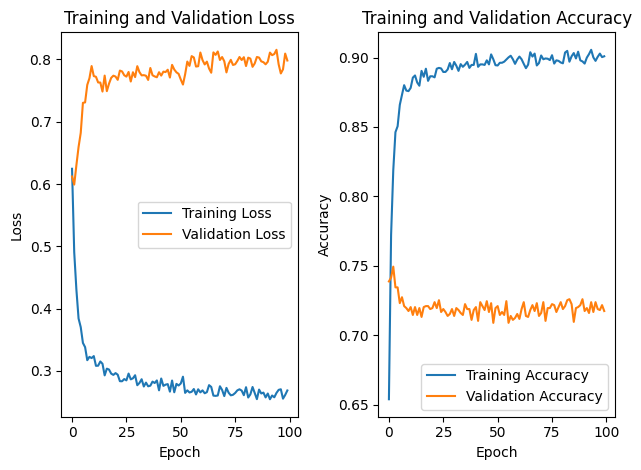


Last Epoch Metrics:
Train Loss: 0.2686
Validation Loss: 0.7984
Train Accuracy: 0.9009
Validation Accuracy: 0.7175
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 11)                297       
                                                                 
 batch_normalization_6 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 11)                0         
                                                                 
 dense_21 (Dense)            (None, 6)                 72        
                                                                 
 batch_normalization_7 (Bat  (None, 6)                 24        
 chNormalization)                                                
     

In [60]:
# So i want to see how well this style of resampling does with unsampled test set 
regModel = Sequential()
regModel.add(Dense(11, activation='relu', input_dim=X_.shape[1]))
regModel.add(BatchNormalization())
regModel.add(Dropout(0.5))
regModel.add(Dense(6, activation='relu'))
regModel.add(BatchNormalization())
regModel.add(Dropout(0.5))
regModel.add(Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=0.001)
regModel.compile(optimizer= opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

plot_training_history(regModel,X_, y_, X_test, y_test)
evaluate_model_performance(regModel,X_, y_, X_test, y_test)

- This just tells me the data we have is not enough and we have a risk of overfitting. 

# My conclusion and Recommendation for production
- As a Ml engineer and data science I would do this:

- Tenure: Tenure is the most important feature, indicating that the duration a customer has been with the service significantly influences churn.

- Contract Type: The type of contract (Month-to-month, Two-year, One-year) is highly influential. Month-to-month contracts have a high impact, followed by Two-year and One-year contracts.

- Monthly and Total Charges: Monthly and Total Charges are also important, suggesting that the cost of the service plays a role in customer churn.

- Internet Service Type: Fiber optic service has a notable impact, while DSL has a relatively lower impact.

- Payment Methods: Electronic check and Mailed check payment methods are among the top contributors.

## Recommendations:

* Retention Strategies: Focus on customer retention strategies, especially for those with shorter tenures. Encourage longer-term contracts to improve customer loyalty.

* Pricing Strategies: Consider reviewing and optimizing pricing plans, especially for Month-to-month contracts. This might involve offering discounts for longer-term commitments.

* Service Quality: Investigate and potentially address issues related to Fiber optic service, as it seems to be associated with higher churn.

* Payment Methods: Explore options to encourage the use of payment methods other than Electronic check and Mailed check.

* Customer Education: Educate customers about the benefits of longer-term contracts and provide clear information about charges to manage expectations.

# From Lab to Production:

Beyond the technical nuances, this project is an exploration into the practicality of machine learning in a real-world scenario. Imagine a scenario where stakeholders can input customer information, and with a click, unveil the likelihood of churn. This model holds the potential to guide targeted marketing campaigns, optimizing resources and enhancing customer retention strategies.

In this narrative, I position myself as a Machine Learning Engineer weaving a story, not just of algorithms and accuracy scores, but of actionable insights and tangible business impact. This journey is a testament to my commitment to leveraging machine learning for strategic decision-making and contributing to the evolution of data-driven practices.

# Saving model and journey into production.


In [61]:
import pickle
filename = 'Churn_model.sav'
pickle.dump(reg_model_NR, open(filename, 'wb'))